# Regresja liniowa

Regresja liniowa to pierwszy i najbardziej podstawowy "model", który 
pewnie część z Was zna ze studiów. 

Mamy zmienną zależną (np. cena nieruchomości) i zmienną objaśniającą 
(np. wielkość nieruchomości w metrach kw). Na podstawie danych historycznych 
chcielibyśmy odkryć zależność między tymi zmiennymi. 

W przypadku regresji liniowej model dopasowuje tylko liniowe zależność między 
cechami. Możemy to stwierdzić naocznie np. rysując wykresy z danych historycznych.

Można użyć regresji liniowej aby dopasować model do zależności nieliniowych ale wymaga to przygotowania odpowiednich cech.

Korzystamy ze zbioru cen mieszkań znanego z 02_data_exploration

**Zadanie: przewidzieć cenę mieszkań na podstawie danych**

In [1]:
import pandas as pd
import sklearn.model_selection
import sklearn.linear_model
import sklearn.metrics
import seaborn as sns
import math
%matplotlib inline  

In [2]:
r = pd.read_csv('ceny_mieszkan_w_poznaniu.tsv', sep = '\t')

# podział na zbiór trenujący/testowy

r_train, r_test = sklearn.model_selection.train_test_split(r[r.price < 500000], test_size = 0.1, random_state=123) 

In [3]:
len(r_train)

1344

Zakładamy w naszym przypadku, że cena będzie funkcją liniową (afiniczną) ilości metrów kwadratowych mieszkania. Jest to założenie logiczne- nim więcej metrów, tym większej ceny się spodziewamy.

Jeżeli zależność jest liniowa powinniśmy być w stanie narysować prostą przebiegającą możliwie blisko wszystkich naszych obserwacji.

/home/local/ALLEGROGROUP/jakub.pokrywka/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


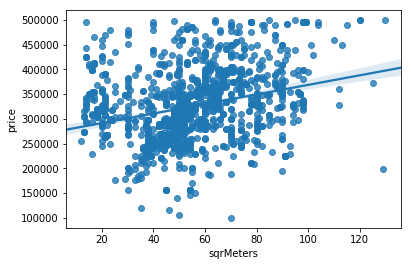

In [4]:
sns.regplot(r_train.sqrMeters, r_train.price) # rzeczywiście - im więcej metrów kw. tym większa cena

Zależność której szukamy możemy zapisać w postaci prostej funkcji $h= ax + b$, gdzie:
* $h$- prognozowana przez nas cena mieszkania,
* $x$- ilość metrów,
* $a$- nieznany parametr
* $b$- nieznany parametr

Pozostaje tylko odnaleźć brakujące wartości $a$ i $b$ na podstawie danych historycznych. **Skąd bedziemy wiedzieli że znaleźliśmy właściwe wartości?**

### Jak ocenić jakość naszego modelu?

Najlepiej, żeby punkty (rzeczywiste, historyczne wartości) leżały na naszej prostej albo jak najlbliżej. Dla konkretnego $x$ kwadrat odległość rzeczywistej ceny $y$ od prognozowanej przez nas wartości ceny $h$ będziemy wynosi: : $$(y - h)^2$$ (kwadrat nakłada duże kary na większy dystans).


Uśredniając po wszystkich punktach i biorąc pierwiastek z sumy:

$$ RMSE = \sqrt{\, \frac{1}{m} \sum_{i = 1}^{m} \left( h^{(i)} - y^{(i)} \right) ^2 }$$


Graficznie można to przedstawić tak:

![](ml_introduction_pictures/residual.png)


![](residual.png)


### Znalezienie parametrów

**Jak znaleźć prostą która najlepiej wpasowuje się w nasze dane?**

Nasz model to funkcja liniowa $y = ax + b$ to czego nie wiemy to wartości parametrów $a$ i $b$ dla których RMSE będzie miało najmniejszą wartość.

Czyli chcemy znaleźć takie $a$ i $b$, żeby
$$ RMSE = \sqrt{\, \frac{1}{m} \sum_{i = 1}^{m} \left( h^{(i)} - y^{(i)} \right) ^2 } = \sqrt{\, \frac{1}{m} \sum_{i = 1}^{m} \left( ax + b - y^{(i)} \right) ^2 } $$ było najmniejsze.

Szukamy więc minimum funkcji RMSE (dla zmiennych $a$ i $b$). Implementacja może bazować na odwracaniu macierzy (bardzo kosztowne obliczeniowo) albo na metodach iteracyjnych - metody gradientu prostego, które są szybkie, ale nie zawsze dają optymalne rozwiazanie.

### Praktyka w sklearn

W prakyce parametry $a$ i $b$ znajdowane są automatycznie przez bibliotekę. Łatwo znaleźć RMSE (chcemy jak najmniejsze) i zilustrować algorytm dla różnie wybranych zmiennych niezależnych.

Szukajac właściwego modelu często patrzymy na różnego rodzaju baseline'y. W tym przypadku naturalnym estymatorem dla ceny mieszkania może być średnia cena wyliczona na podstawie całeo zbioru testowego. *Jakie RMSE ma taki "model"?*

In [5]:
# tego typu modele nazywane są często 'dummy'. Ich implementacje dla regresji można znaleźć tu:
# https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html#sklearn.dummy.DummyRegressor

In [6]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor()
dummy.fit(r_train[['sqrMeters']], r_train.price)
predictions = dummy.predict(r_test[['sqrMeters']])

baseline_RMSE = math.sqrt(mean_squared_error(predictions, r_test.price))
print('Baseline test RMSE: ', baseline_RMSE)

Baseline test RMSE:  74534.47356600285


In [7]:
def evaluate_regression(column_name):
     # narysujmy wykres danej cechy w funkcji ceny
    sns.regplot(r_train[column_name], r_train.price)

    # jakie RMSE uzyskamy dla tej cechy?
    m1 = sklearn.linear_model.LinearRegression()
    
    # w ten sposób podajemy kolumny jako listę wartości do naszego modelu
    # niestety nie akceptuje on pd.Series więc konwertujemy ją do listy
    X_train = r_train[column_name].values.reshape(-1, 1)
    y_train = r_train.price.values.reshape(-1, 1)
    
    # właściwe trenowanie modelu
    m1.fit(X_train,y_train)
    
    # otrzymane wartości współczynników kierunkowych
    print('a =',m1.coef_)
    print('b =',m1.intercept_)
    
    # obliczanie RMSE dla zbioru testowego i trenującego
    h_train = m1.predict(X_train)
    X_test = r_test[column_name].values.reshape(-1, 1)
    y_test = r_test.price.values.reshape(-1, 1)
    h_test = m1.predict(X_test)
    print('train RMSE = ',math.sqrt(sklearn.metrics.mean_squared_error(h_train,y_train)))
    print('test RMSE = ',math.sqrt(sklearn.metrics.mean_squared_error(h_test,y_test)))
    print('baseline RMSE = ', baseline_RMSE)
    return m1

a = [[965.46131294]]
b = [272153.1083317]
train RMSE =  69740.16748725633
test RMSE =  70122.43934863913
baseline RMSE =  74534.47356600285


/home/local/ALLEGROGROUP/jakub.pokrywka/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

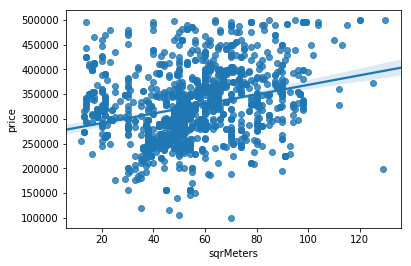

In [8]:
evaluate_regression('sqrMeters')

a = [[-1445.77587354]]
b = [329778.34044728]
train RMSE =  72422.31586590195
test RMSE =  74834.68030821579
baseline RMSE =  74534.47356600285


/home/local/ALLEGROGROUP/jakub.pokrywka/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

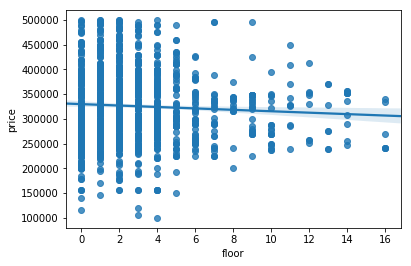

In [9]:
evaluate_regression('floor')

a = [[54412.41326292]]
b = [185144.34188299]
train RMSE =  61582.79303510356
test RMSE =  59198.93983698945
baseline RMSE =  74534.47356600285


/home/local/ALLEGROGROUP/jakub.pokrywka/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

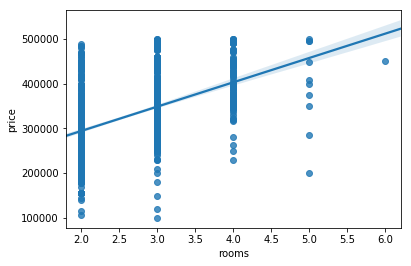

In [10]:
evaluate_regression('rooms')

a = [[793.42000263]]
b = [324895.96928382]
train RMSE =  72546.97621184742
test RMSE =  74539.77296828374
baseline RMSE =  74534.47356600285


/home/local/ALLEGROGROUP/jakub.pokrywka/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

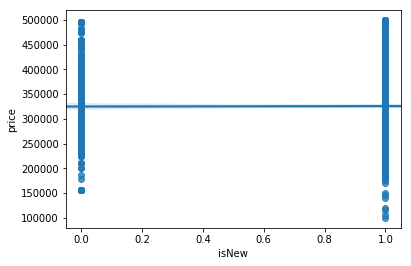

In [11]:
# jak widać można używać cechy jakościowej binarnej
evaluate_regression('isNew')
# tutaj wynik jest kiepski

# Ex. 1

Jaką cene będzie miało według modelu opartego o liczbę pokoi mieszkanie, które ma 7 pokoi?

In [12]:
# ?
regr = sklearn.linear_model.LinearRegression()
X_train = r_train['rooms'].values.reshape(-1, 1)
y_train = r_train.price.values.reshape(-1, 1)
regr.fit(X_train,y_train)

print(regr.predict([[7]]))

[[566031.23472339]]


### Jakich cech możemy używać?

**Zmienne ilościowe ciągłe (np. metry kw, długość) i dyskretne (np. liczba pokoi, liczba dzieci)** sa ok. Dla **zmiennej ilościowej porządkowej (np. wykształcenie, ocena w szkole, godzina wystapienia zdarzenia)** model będzie dawał jakiś wynik (choć niekoniecznie formalnie poprawne jest jego użycie, gdyż założenie liniowości nie będzie spełnione).

**Zmienne jakościowe binarne** sa ok (jak widać wyżej)

**Zmiennych jakościowe o więcej niz 2 klasach** nie wrzucamy do modelu tak po prostu (a nawet jeżeli byśmy chcieli, to w jakiej kolejnosci np. zmapować religie na integery i jaką dostaniemy informację z modelu?)

Zmienne jakościowe możemy:
* usunać z modelu
* stworzyć tyle modeli ile jest kombinacji zmiennych jakościowych
* użyć one hot encoding (o tym później) lub innej reprezentacji

### Jakie wybrać cechy

Oczywiście takie, które dają najmniejszy RMSE. Najlepsze będą cechy skorelowane liniowo ze zmienną zależną:

In [13]:
r.corr()['price']

price        1.000000
isNew        0.034873
rooms        0.508833
floor       -0.068882
sqrMeters    0.422073
Name: price, dtype: float64

Jak widać **sqrMeters** ma wysoką korelację, a **liczba pokoi** jeszcze wyższą

### Regresja wielu zmiennych

Oczywiście regresja nie musi być funkcją jednej zmiennej. Może być także funkcją wielu zmiennych (np. ilości metrów kwadratowych oraz ilości pokoi. Model wygląda wtedy: $$h = a_1 * x_1 + a_2 * x_2  + b$$ i szukamy wtedy $a_1$, $a_2$, $b$.


Dostaniemy wtedy lepszy wynik na zbiorze trenującym. Lepiej jednak nie używać nieskorelowanych liniowo cech, gdyż na zbiorze testowym raczej nie będą dawać lepszych wyników oraz komplikują model.

Sprawdźmy jak będzie wyglądał model 2 zmiennych (tracimy możliwość łatwej wizualizacji):

In [14]:
features = ['sqrMeters', 'rooms']
label = ['price']

m1 = sklearn.linear_model.LinearRegression()
X_train = r_train[features]
y_train = r_train[label].values.reshape(-1, 1)

X_test = r_test[features]
y_test = r_test[label].values.reshape(-1, 1)
m1.fit(X_train,y_train)

h_train = m1.predict(X_train)
h_test = m1.predict(X_test)
print('a1, a2  =',m1.coef_[0])
print('b=',m1.intercept_)

h_train = m1.predict(X_train)
print('RMSE train: ',math.sqrt(sklearn.metrics.mean_squared_error(h_train,y_train)))
print('RMSE test: ',math.sqrt(sklearn.metrics.mean_squared_error(h_test,y_test)))
print('baseline RMSE: ', baseline_RMSE)

a1, a2  = [  508.39004068 50437.46408562]
b= [167321.41792419]
RMSE train:  60741.37355113291
RMSE test:  57780.49412778707
baseline RMSE:  74534.47356600285


In [15]:
m1.coef_

array([[  508.39004068, 50437.46408562]])

In [16]:
m1.intercept_

array([167321.41792419])

Jak widać RMSE jest jeszcze mniejsze.

**Regresja liniowa jest bardzo czuła na obserwacje odstające.** 

Warto też rozważyć eliminacje danych odstających z modelu. Proste modele takie jak regresja liniowa mają ograniczoną pojemność informacyjną aby dobrze działały konieczny może być spory wysiłek jeżeli chodzi o przygotowanie danych wejściowych. 

Najprostszą heurystyką do usuwania outlierów jest wybranie progu wartości od którego usuwamy obserwacje odstające

### Cechy regresji liniowej

#### Zakłada liniowość zmiennej zależnej względem zmiennej/zmiennych niezależnych
Nie zawsze jest to założenie zgodne z rzeczywistością (np. na drugim rysunku widać korelację kwadratową, a nie liniową:

![przed skalowaniem](anscombe.png)

Oczywiście jako modelu możemy użyć także funkcji kwadratowej, logarytmicznej, dowolnego wielomianu wielu zmiennych (zależy od danych)


#### Ze zmiennymi jakościowymi musimy się trochę pomęczyć (uwaga wyżej)

#### Regresja jest podstawą działania sieci neuronowych (sieć neuronowa tak naprawdę składa się z wielu regresji przedzielanych nieliniowymi funkcjami aktywacji)


#### Nie musimy minimaliować akurat RMSE
Może to być tez po np. odległość absolutna: $$ \frac{1}{m} \sum_{i = 1}^{m} \| \left( h^{(i)} - y^{(i)} \right) \|$$

#### ZADANIE: Zrób wszystkie ćwiczenia z tego arkusza ze zbiorem ceny_aut_w_polsce.tsv, w szczególnosci:

* znajdź cechę która daje najlepszy wynik, wylicz dla niej RMSE i narysuj wykres
* to samo z 2 cechami
* to samo ze wszystkimi cechami

**Ten zbiór jest o wiele większy, więc wyniki będą bardziej stabilne**